# TD2C-D2C, Linear Processes Validation

This notebook aims to validate the `TD2C` method specifically within the context of linear processes. The focus is on examining how well the `TD2C` framework performs when applied to various linear time series models, ensuring robustness and accuracy in its causal discovery.

## Validation Strategies:

1. **Validate for Linear Processes**: The notebook will first validate the `TD2C` method on datasets generated from classic linear processes such as AR (AutoRegressive) and MA (Moving Average) models. This step ensures that `TD2C` can accurately identify causal relationships in well-defined, synthetic linear systems.

2. **Train on Linear Processes and Validate for Real Data**: Next, the notebook will train the `TD2C` method on datasets generated from linear processes and then apply the trained model to real-world data. This strategy tests the method's generalization capability from synthetic linear models to complex, real-world scenarios.

With this notebook, you'll be able to generate linear process datasets, train and validate the `TD2C` method, and compare its performance across different scenarios, including synthetic and real-world data, as well as standardized benchmarks.


# Settings

## Packages

In [3]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [4]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = -1 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [5]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20] 
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]:
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/'))


P18_N5_Nj2_n0.01 done
P20_N5_Nj2_n0.01 done
P19_N5_Nj2_n0.01 done


4

# Descriptors Generation & Classification

#### Descriptors Generation

In [9]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


#### Run Classifier

In [3]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [11]:
# choose the way of running the validation phase

mode = 'LOPOCV_lin'  
# 'LOPOCV_all' = train the model on all processes except the one being tested
# 'LOPOCV_lin' = train the model on processes 18, 19 and 20 separately and test on the rest
# 'combined_training' = train the model on processes 18, 19 and 20 combined and test on the rest
# 'LOPOCV_mixture' = train the model on processes 18, 19 and 20 and 3 nonlinear processes separately and test on the rest

# Define the processes you're using for training
all_processes = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
subset_processes = [18, 19, 20]
subset_mixture = [18, 19, 20, 1, 6, 15]

# Initialize dictionaries to store results
td2c_rocs_process = {}
td2c_precision_process = {}
td2c_recall_process = {}
td2c_f1_process = {}

# Loop over all files
for n_vars, todo in todos.items():
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # Check if the process is in the list of processes we want to estimate
        if gen_process_number not in all_processes:
            continue

        # Select training processes based on the mode
        if mode == 'LOPOCV_all':
            train_processes = [p for p in all_processes if p != gen_process_number]
        elif mode == 'LOPOCV_lin':
            if gen_process_number not in subset_processes:
                continue
            for leave_out_process in subset_processes:
                train_processes = [p for p in subset_processes if p != leave_out_process]
        elif mode == 'combined_training':
            train_processes = subset_processes
        elif mode == 'LOPOCV_mixture':
            if gen_process_number not in subset_mixture:
                continue
            for leave_out_process in subset_mixture:
                train_processes = [p for p in subset_mixture if p != leave_out_process]
        else:
            raise ValueError("Invalid mode selected. Choose 'LOPOCV_all', 'LOPOCV_lin', or 'combined_training'.")

        # Train on the selected processes
        training_data = descriptors_training.loc[descriptors_training['process_id'].isin(train_processes)]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal'])
        y_train = training_data['is_causal']

        # Initialize and train the model
        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        model.fit(X_train, y_train)

        # Save the model for reproducibility
        if mode == 'LOPOCV_all':
            model_filename = f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/models/all_proc/td2c_R_N5_{gen_process_number}.pkl'
        elif mode == 'LOPOCV_lin':
            model_filename = f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/models/lin_proc/td2c_R_N5_LOPO_{leave_out_process}.pkl'
        elif mode == 'combined_training':
            model_filename = f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/models/lin_proc/td2c_R_N5_LOPO_combined.pkl'
        elif mode == 'LOPOCV_mixture':
            model_filename = f'/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/data/models/mixture_proc/td2c_R_N5_LOPO_{leave_out_process}.pkl'
        
        with open(model_filename, 'wb') as f:
            pickle.dump(model, f)

        # Test on all processes, including the ones we didn't train on
        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            testing_data = descriptors_training.loc[
                (descriptors_training['process_id'] == gen_process_number) & 
                (descriptors_training['n_variables'] == n_variables) & 
                (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & 
                (descriptors_training['noise_std'] == noise_std) & 
                (descriptors_training['graph_id'] == graph_id)
            ]
            
            test_df = testing_data.sort_values(by=['edge_source', 'edge_dest']).reset_index(drop=True)
            
            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal'])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s


100%|██████████| 18/18 [00:17<00:00,  1.00it/s]


#### Save Results

In [12]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)

#### Load Data

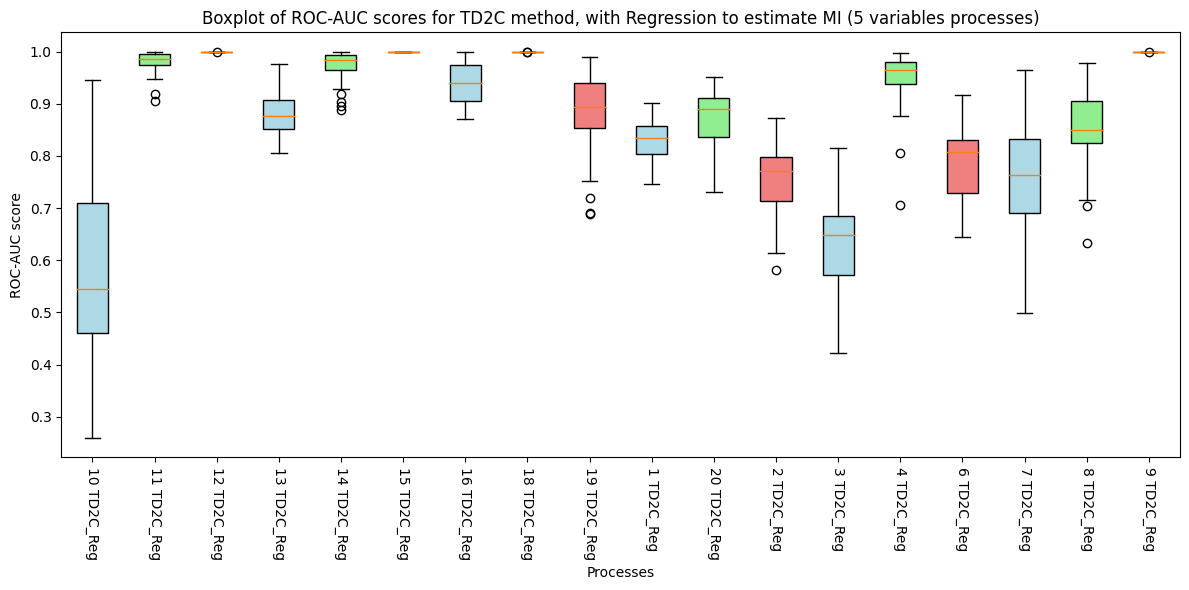

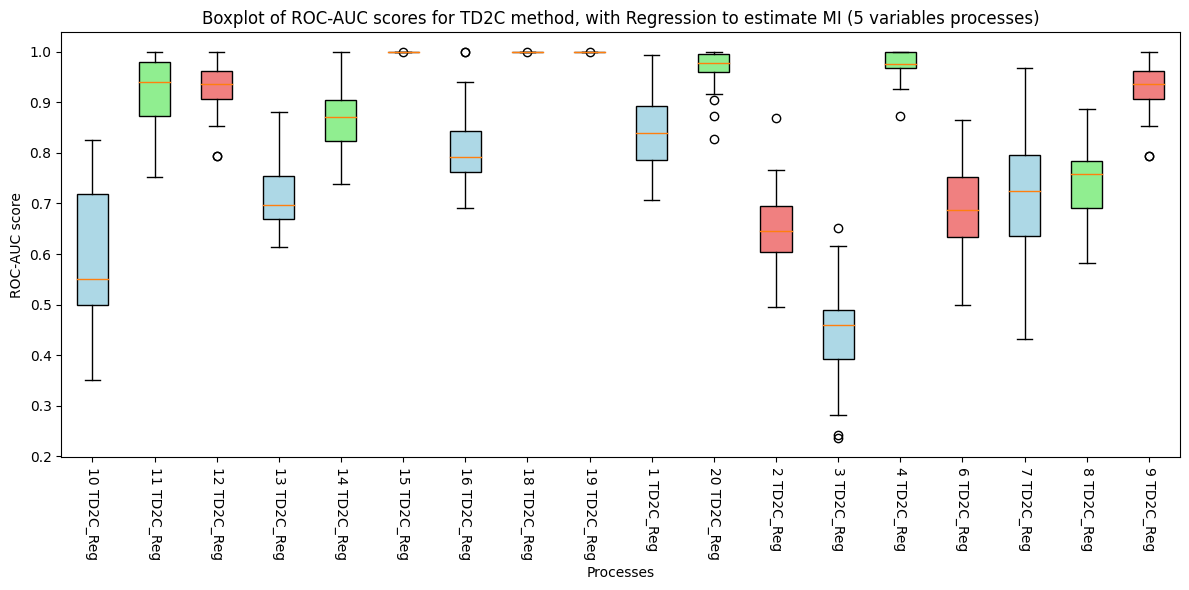

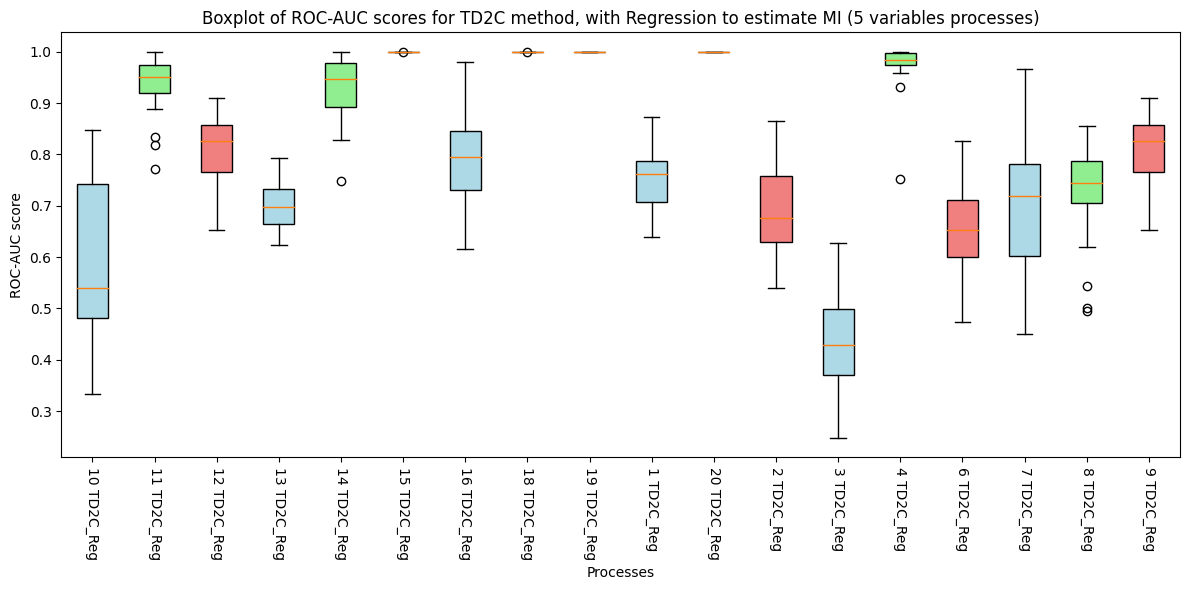

In [13]:
#################################################################### LOAD DATA #####################################################################
input_folder_1 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/all_proc/'
input_folder_2 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/lin_proc/'
input_folder_3 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/mixture_proc/'

with open(os.path.join(input_folder_1, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process_all, TD2C_precision_process_all, TD2C_recall_process_all, TD2C_f1_process_all = pickle.load(f)

with open(os.path.join(input_folder_2, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process_lin, TD2C_precision_process_lin, TD2C_recall_process_lin, TD2C_f1_process_lin = pickle.load(f)

with open(os.path.join(input_folder_2, 'journal_results_td2c_R_N5_combined.pkl'), 'rb') as f:
    TD2C_rocs_process_lin_combined, TD2C_precision_process_lin_combined, TD2C_recall_process_lin_combined, TD2C_f1_process_lin_combined = pickle.load(f)

with open(os.path.join(input_folder_3, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process_mixture, TD2C_precision_process_mixture, TD2C_recall_process_mixture, TD2C_f1_process_mixture = pickle.load(f)



#### Plot

In [ ]:

##################################################################### PLOT #########################################################################

# all processes validated model

df1 = pd.DataFrame(TD2C_rocs_process_all)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()



# linear processes validated model

df1 = pd.DataFrame(TD2C_rocs_process_lin)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()



# linear processes combined validated model

df1 = pd.DataFrame(TD2C_rocs_process_lin_combined)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

In [15]:
# all processes validated model
input_folder_1 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/all_proc/'

# print a dataframe for these results
with open(os.path.join(input_folder_1, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process_all, TD2C_precision_process_all, TD2C_recall_process_all, TD2C_f1_process_all = pickle.load(f)

# Create a dataframe with the results
df_roc_1 = pd.DataFrame(TD2C_rocs_process_all)

# average each column
df_roc_1 = df_roc_1.mean().mean()

print(f'ROC-AUC for TD2C trained on all processes is {round(df_roc_1, 3)}')

# linear processes validated model
input_folder_2 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/lin_proc/'

# print a dataframe for these results
with open(os.path.join(input_folder_2, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process_lin, TD2C_precision_process_lin, TD2C_recall_process_lin, TD2C_f1_process_lin = pickle.load(f)

# Create a dataframe with the results
df_roc_2 = pd.DataFrame(TD2C_rocs_process_lin)

# average each column
df_roc_2 = df_roc_2.mean().mean()

print(f'ROC-AUC for TD2C trained only on processes 18, 19 and 20 (linear) processes is {round(df_roc_2, 3)}')


# linear processes combined validated model
input_folder_2 = '/home/jpalombarini/td2c/notebooks/contributions/Linear_processes_validation/results/Regression/journals/lin_proc/'

# print a dataframe for these results
with open(os.path.join(input_folder_2, 'journal_results_td2c_R_N5_combined.pkl'), 'rb') as f:
    TD2C_rocs_process_lin, TD2C_precision_process_lin, TD2C_recall_process_lin, TD2C_f1_process_lin = pickle.load(f)

# Create a dataframe with the results
df_roc_3 = pd.DataFrame(TD2C_rocs_process_lin)

# average each column
df_roc_3 = df_roc_3.mean().mean()

print(f'ROC-AUC for TD2C trained only on processes 18, 19 and 20 COMBINED (linear) processes is {round(df_roc_3, 3)}')

if df_roc_1 > df_roc_2:
    print('As we expected, the model trained on all processes is better')

if df_roc_2 > df_roc_3:
    print('As we expected, the model trained on linear processes with LOPO is better than the combined model')


ROC-AUC for TD2C trained on all processes is 0.872
ROC-AUC for TD2C trained only on processes 18, 19 and 20 (linear) processes is 0.823
ROC-AUC for TD2C trained only on processes 18, 19 and 20 COMBINED (linear) processes is 0.806
As we expected, the model trained on all processes is better
As we expected, the model trained on linear processes with LOPO is better than the combined model
